In [19]:
import torch
import tqdm
import numpy as np
torch.manual_seed(1488)
# from pytekvel.preprocessing import Decomposer
import joblib
from torch import nn
from utils import DatasetWindowed, Decomposer
from utils import get_model_preds_probas_targets, custom_metric_torch_batch, double_metric
from torch.utils.data import DataLoader

from monitoring import Monitor

from plotly import graph_objects as go

dataset_root_path = './dataset'
start_idx = 80*20

In [2]:
class RNNModel(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            # nn.Sigmoid()
        )
        
    def forward(self, x):
        
        rnn_out, _ = self.rnn(x)
        out = self.fc(rnn_out)  # (batch_size, sequence_length, output_size=1)
        out = out.squeeze(-1) # (batch_size, sequence_length)
        return out

In [3]:
data_train = joblib.load(dataset_root_path + "/train/data-multi-train-fixed.joblib")
labels_train = joblib.load(dataset_root_path + "/train/labels-multi-train-fixed.joblib")

data_train = Decomposer(maxcurrent=500).normalize(data_train)
data_train = np.array(data_train)
labels_train = np.array(labels_train)

train_embs = DatasetWindowed(data_train, labels_train, wsize=256, stride=1, start_idx=start_idx)
print('Train Set')
print(len(train_embs))
data, target = train_embs[0]
print(type(data), type(target))
print(data.shape, target.shape, '\n')

Train Set
3941
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([4001, 256]) torch.Size([4001]) 



In [4]:
data, label = train_embs[0]
label.shape

torch.Size([4001])

In [5]:
data_test = joblib.load(dataset_root_path + "/test/data-multi-test-fixed.joblib")
labels_test = joblib.load(dataset_root_path + "/test/labels-multi-test-fixed.joblib")

data_test = Decomposer(maxcurrent=500).normalize(data_test)
data_test = np.array(data_test)
labels_test = np.array(labels_test)

test_embs = DatasetWindowed(data_test, labels_test, wsize=256, stride=1, start_idx=start_idx)
print('Test Set')
print(len(test_embs))
data, target = test_embs[0]
print(type(data), type(target))
print(data.shape, target.shape)

Test Set
1971
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([4001, 256]) torch.Size([4001])


In [6]:
loader_train = DataLoader(train_embs, batch_size=32, shuffle=False)
batch = next(iter(loader_train))
batch_data, batch_target = batch
print('Train Batch')
print(batch_data.shape)
print(batch_target.shape)


Train Batch
torch.Size([32, 4001, 256])
torch.Size([32, 4001])


In [7]:
loader_test = DataLoader(test_embs, batch_size=32, shuffle=False)
batch = next(iter(loader_test))
batch_data, batch_target = batch
print('Test Batch')
print(batch_data.shape)
print(batch_target.shape)

Test Batch
torch.Size([32, 4001, 256])
torch.Size([32, 4001])


In [8]:
num_epochs = 100
FN_punish = 20.0
proba_threshold = 0.5
learning_rate = 0.001
betas = (0.907, 0.999)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
        print(f"Active GPU: {torch.cuda.get_device_name(device)}")
else:
    print("Now CPU is used")

model = RNNModel(embedding_size=256, hidden_size=128).to(device)
pos_w = torch.tensor([FN_punish], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(weight=pos_w) #punishes for False Negatives
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=betas)


monitor = Monitor()

Active GPU: NVIDIA RTX A5000


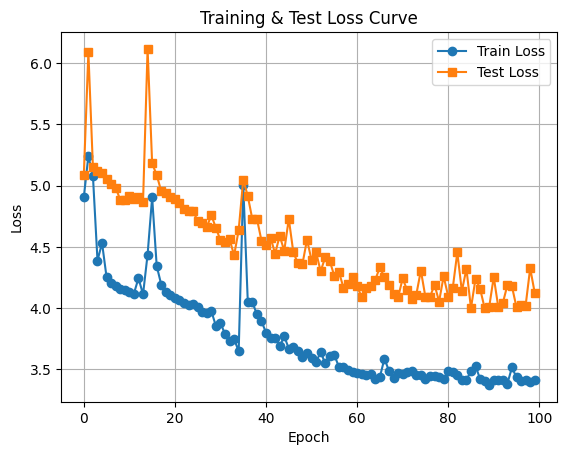

In [9]:
# Train loop
for epoch in range(num_epochs):
    print("-"*50)
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    model.train()
    train_loss = 0.0
    train_score = 0.0
    
    itr_obj = tqdm.tqdm(loader_train, total=len(loader_train), desc='   Training')
    for batch_data, batch_target in itr_obj:
        batch_data, batch_target = batch_data.to(device), batch_target.to(device)

        # Forward pass
        out_logits = model(batch_data) #logits
        loss = criterion(out_logits, batch_target.float()) #as logits

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        probas = torch.sigmoid(out_logits)
        preds_binary = probas >= proba_threshold
        
        score = custom_metric_torch_batch(y_true=batch_target, y_pred=preds_binary)
        # print(f"    AVG Train Score (over {len(batch_data)} units): {score_mean * 100:.4f}%")
        # print(score[score != 0.0].size())
        train_score += score.mean()

    
    model.eval()
    test_loss = 0.0
    test_score = 0.0

    with torch.no_grad():
        itr_obj = tqdm.tqdm(loader_test, total=len(loader_test), desc=' Evaluation')
        for batch_data, batch_target in itr_obj:
            batch_data, batch_target = batch_data.to(device), batch_target.to(device)
            out_logits = model(batch_data)
            loss = criterion(out_logits, batch_target.float())
            test_loss += loss.item()
            probas = torch.sigmoid(out_logits)
            preds_binary = probas >= proba_threshold
            score_mean = custom_metric_torch_batch(y_true=batch_target, y_pred=preds_binary).mean()
            # print(f"    AVG Train Score (over {len(batch_data)} units): {score_mean * 100:.4f}%")
            test_score += score_mean
    
    monitor
    train_loss /= len(loader_train)
    train_score /= len(loader_train)

    test_loss /= len(loader_test)
    test_score /= len(loader_test)

    monitor.add_train_loss(train_loss)
    monitor.add_test_loss(test_loss)
    monitor.show()
    # print(f"Train Loss : {train_loss:.4f}, Test Loss : {test_loss:.4f}")
    # print(f"Train Score: {train_score}, Test Score: {test_score}")
    # print("-"*50)

In [20]:
# joblib.dump(model, "windowed-rnn-256.joblib")
model = joblib.load("windowed-rnn-256.joblib")

In [22]:
def get_model_preds_probas_targets(model, loader, proba_threshold = 0.5, device="cpu", old = True):
    model.eval()
    

    multipreds = []
    multiprobas = []
    targets = []
    
    with torch.no_grad():
        itr_obj = tqdm.tqdm(loader, total=len(loader), desc=' Evaluation')
        for batch_data, batch_target in itr_obj:
            batch_data, batch_target = batch_data.to(device), batch_target.to(device)
            
            out_logits = model(batch_data)
            # out_logits = out_logits[0] if isinstance(out_logits, tuple) else out_logits
            
            
            probas = torch.sigmoid(out_logits)
            preds_binary = probas >= proba_threshold

            multipreds.append(preds_binary)
            multiprobas.append(probas)
            targets.append(batch_target)


    multipreds = torch.cat(multipreds, dim=0)
    multiprobas = torch.cat(multiprobas, dim=0)
    targets = torch.cat(targets, dim=0)

    return multipreds, multiprobas, targets

In [34]:
proba_tr = 0.6

preds, probas, targets = get_model_preds_probas_targets(model, loader_test, proba_threshold=proba_tr, device=device)
preds = torch.zeros_like(targets, dtype=torch.float32)
print(preds.shape)
print(probas.shape)
print(targets.shape)

test_scores = custom_metric_torch_batch(y_pred=probas > proba_tr, y_true=targets)
print(test_scores.shape)

print(f"Score (>{proba_tr}): {test_scores.mean()*100:.4f}%")

# fig = go.Figure(data=[
#         go.Scatter(y=test_scores.cpu(), name='Unit Scores'),
    
#     ])

# # Add basic styling
# fig.update_layout(
#     title='',
#     xaxis_title='Index',
#     yaxis_title='Score'
# )

# fig.show()

 Evaluation: 100%|██████████| 62/62 [00:01<00:00, 57.86it/s]

torch.Size([1971, 4001])
torch.Size([1971, 4001])
torch.Size([1971, 4001])
torch.Size([1971])
Score (>0.6): 74.7839%


In [27]:
probas.max()

tensor(0.9892, device='cuda:0')

In [15]:
data_test = joblib.load(dataset_root_path + "/test/data-multi-test-fixed.joblib")
labels_test = joblib.load(dataset_root_path + "/test/labels-multi-test-fixed.joblib")

data_test = Decomposer(maxcurrent=500).normalize(data_test)
data_test = np.array(data_test)

unit_idx = 1967
embedding, labels = test_embs[unit_idx]
data = data_test[unit_idx, start_idx:]

model.eval()
with torch.no_grad():
    print(data.shape)
    print(data.shape)
    predict = torch.sigmoid(model(embedding.to(device)))
    print(predict.shape)

    fig = go.Figure(data=[
        go.Scatter(y=data, name='Time-Series'),
        go.Scatter(y=labels, name='Binary Labels'),
        go.Scatter(y=predict.cpu().reshape(-1), name='probas'),
        go.Scatter(y=(predict.cpu().reshape(-1) > proba_tr) * 1.2, name='preds')
    ])

    # Add basic styling
    fig.update_layout(
        title='',
        xaxis_title='Index',
        yaxis_title='Values'
    )

    fig.show()

(4001,)
(4001,)
torch.Size([4001])
